In [136]:
import sys, os
import numpy as np
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
sys.path.append("../../scripts/")
from plt_config import use_latex, TU_GREY, TU_RED
import matplotlib.pyplot as plt
use_latex()
BASIS_PATH = "/home/etschgi1/REPOS/Masterarbeit/scripts/6-31g_2df_p_custom_nwchem.gbs"
data_folder = "plot_data"

In [137]:
from matplotlib.colors import SymLogNorm
def plotwithlabels(X, M, plotname, overlay=None, labels="atoms", colorbar=True, labelsize=8, vmax=1):
    if colorbar:
        fig, ax = plt.subplots(1, 2, figsize=(9, 8), gridspec_kw={'width_ratios': [25, 1]})
    else:
        fig, ax0 = plt.subplots(figsize=(9, 8))
        ax = [ax0]  # damit ax[0] weiterhin funktioniert
    norm = SymLogNorm(linthresh=1e-3, linscale=1.0, vmin=-vmax, vmax=vmax)
    im = ax[0].imshow(X, cmap='RdBu', norm=norm)

    if labels == "atoms":
        from collections import defaultdict
        atom_groups = defaultdict(list)
        for i, label in enumerate(M.ao_labels()):
            key = ' '.join(label.split()[:2])  # z.B. "2 O"
            atom_groups[key].append(i)

        new_ticks = [np.mean(indices) for indices in atom_groups.values()]
        labels_ = [f"{k.split()[1]}$_{{{k.split()[0]}}}$" for k in atom_groups.keys()]
        ax[0].set_xticks(new_ticks)
        ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
        ax[0].set_yticks(new_ticks)
        ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
        ax[0].tick_params(axis='x', labelbottom=True, pad=10 + labelsize)
        ax[0].tick_params(axis='y', labelleft=True, pad=10 + labelsize)

    elif labels == "all":
        labels_ = [f"{label.split()[1]}$_{{{label.split()[0]}}}$: {{{label.split()[2]}}}" for label in M.ao_labels()]
        ax[0].set_xticks(range(len(labels_)))
        ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
        ax[0].set_yticks(range(len(labels_)))
        ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
        ax[0].tick_params(axis='x', labelbottom=True, pad=30)
        ax[0].tick_params(axis='y', labelleft=True, pad=30)

    ax[0].grid(False)

    ao_labels = M.ao_labels()
    atom_names = [label.split()[1] + label.split()[0] for label in ao_labels]
    boundaries = [i for i in range(1, len(atom_names)) if atom_names[i] != atom_names[i-1]]
    for b in boundaries:
        ax[0].axhline(b - 0.5, color='gray', lw=0.5)
        ax[0].axvline(b - 0.5, color='gray', lw=0.5)

    if colorbar:
        cb = plt.colorbar(im, cax=ax[1])
        cb.ax.tick_params(labelsize=12)
        cb.ax.grid(False)

    if overlay is not None:
        overlay_img = mpimg.imread(overlay)
        imagebox = OffsetImage(overlay_img, zoom=0.21)
        ab = AnnotationBbox(imagebox, (0.69, 0.72), frameon=False, xycoords='axes fraction')
        ax[0].add_artist(ab)

    plt.savefig(f"{plotname}", bbox_inches="tight", dpi=600)

In [138]:
import matplotlib.patches as mpatches
def add_hatched_region(ax, row_start, row_end, col_start, col_end,
                       hatch='///', edgecolor='gray', linewidth=0):
    width  = col_end - col_start + 1
    height = row_end - row_start + 1
    rect = mpatches.Rectangle(
        (col_start - 0.5, row_start - 0.5),
        width, height,
        fill=False,
        hatch=hatch,
        edgecolor=edgecolor,
        linewidth=linewidth,
        alpha=0.5
    )
    ax.add_patch(rect)

def plotschematicBlocks(X, M, plotname, hatched_regions = [], overlay=None, colorbar=True, labelsize=8, vmax=1):
    if colorbar:
        fig, ax = plt.subplots(1, 2, figsize=(9, 8), gridspec_kw={'width_ratios': [25, 1]})
    else:
        fig, ax0 = plt.subplots(figsize=(9, 8))
        ax = [ax0]  # damit ax[0] weiterhin funktioniert
    norm = SymLogNorm(linthresh=1e-1, linscale=1.0, vmin=-vmax, vmax=vmax)

    im = ax[0].imshow(X, cmap='RdBu', norm=norm)


    labels_ = [f"{label.split()[1]}$_{{{label.split()[0]}}}$: ${{{label.split()[2][:2]}}}$" for label in M.ao_labels()]
    ax[0].set_xticks(range(len(labels_)))
    ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
    ax[0].set_yticks(range(len(labels_)))
    ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
    ax[0].tick_params(axis='x', labelbottom=True, pad=30)
    ax[0].tick_params(axis='y', labelleft=True, pad=30)

    for label, hatch, row_col_indices in hatched_regions:
        row_start, row_end, col_start, col_end = row_col_indices
        add_hatched_region(ax[0], row_start, row_end, col_start, col_end, hatch=hatch)
        # add distinct hatch label to legend
        
    if hatched_regions:
     seen = {}
     handles = []
     for label, hatch, _ in hatched_regions:
         if hatch not in seen:
             seen[hatch] = label
             patch = mpatches.Patch(
                 facecolor='none',
                 hatch=hatch,
                 edgecolor='gray',
                 linewidth=1,
                 label=label
             )
             handles.append(patch)

     ax[0].legend(
         handles=handles,
         loc='lower center',
         bbox_to_anchor=(0.5, 0.99),
         ncol=len(handles),
         frameon=False,
         fontsize=1.5*labelsize
     )

    ax[0].grid(False)

    ao_labels = M.ao_labels()
    atom_names = [label.split()[1] + label.split()[0] for label in ao_labels]
    boundaries = [i for i in range(1, len(atom_names)) if atom_names[i] != atom_names[i-1]]
    for b in boundaries:
        ax[0].axhline(b - 0.5, color=TU_GREY, lw=1.5)
        ax[0].axvline(b - 0.5, color=TU_GREY, lw=1.5)

    if colorbar:
        cb = plt.colorbar(im, cax=ax[1])
        cb.ax.tick_params(labelsize=12)
        cb.ax.grid(False)

    if overlay is not None:
        overlay_img = mpimg.imread(overlay)
        imagebox = OffsetImage(overlay_img, zoom=0.21)
        ab = AnnotationBbox(imagebox, (0.69, 0.72), frameon=False, xycoords='axes fraction')
        ax[0].add_artist(ab)

    plt.savefig(f"{plotname}", bbox_inches="tight", dpi=600)
    

In [139]:
from scf_guess_tools import load, calculate, guess, Backend
from pyscf import gto, dft

In [140]:
filepath = "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/xyz/dsgdb9nsd_000003.xyz"
mol = load(filepath, basis=BASIS_PATH, backend=Backend.PY)
wf = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")
density = wf.density()

Using basis from /home/etschgi1/REPOS/Masterarbeit/scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -72.5576535314887


In [141]:
mol = gto.Mole()
mol.atom = filepath
mol.basis = BASIS_PATH
mol.unit = 'Angstrom'
mol.charge = 0
mol.spin = 0
mol.symmetry = False
mol.build()

# RKS-DFT mit PBE
mf = dft.RKS(mol)
mf.xc = 'b3lypg'                # DFT-Funktional (z.B. 'B3LYP', 'PBE', 'LDA' ...)
mf.conv_tol = 1e-10           # Konvergenz-Toleranz
mf.kernel()
density = mf.make_rdm1()
density = density / density.max()

converged SCF energy = -72.5785257889163


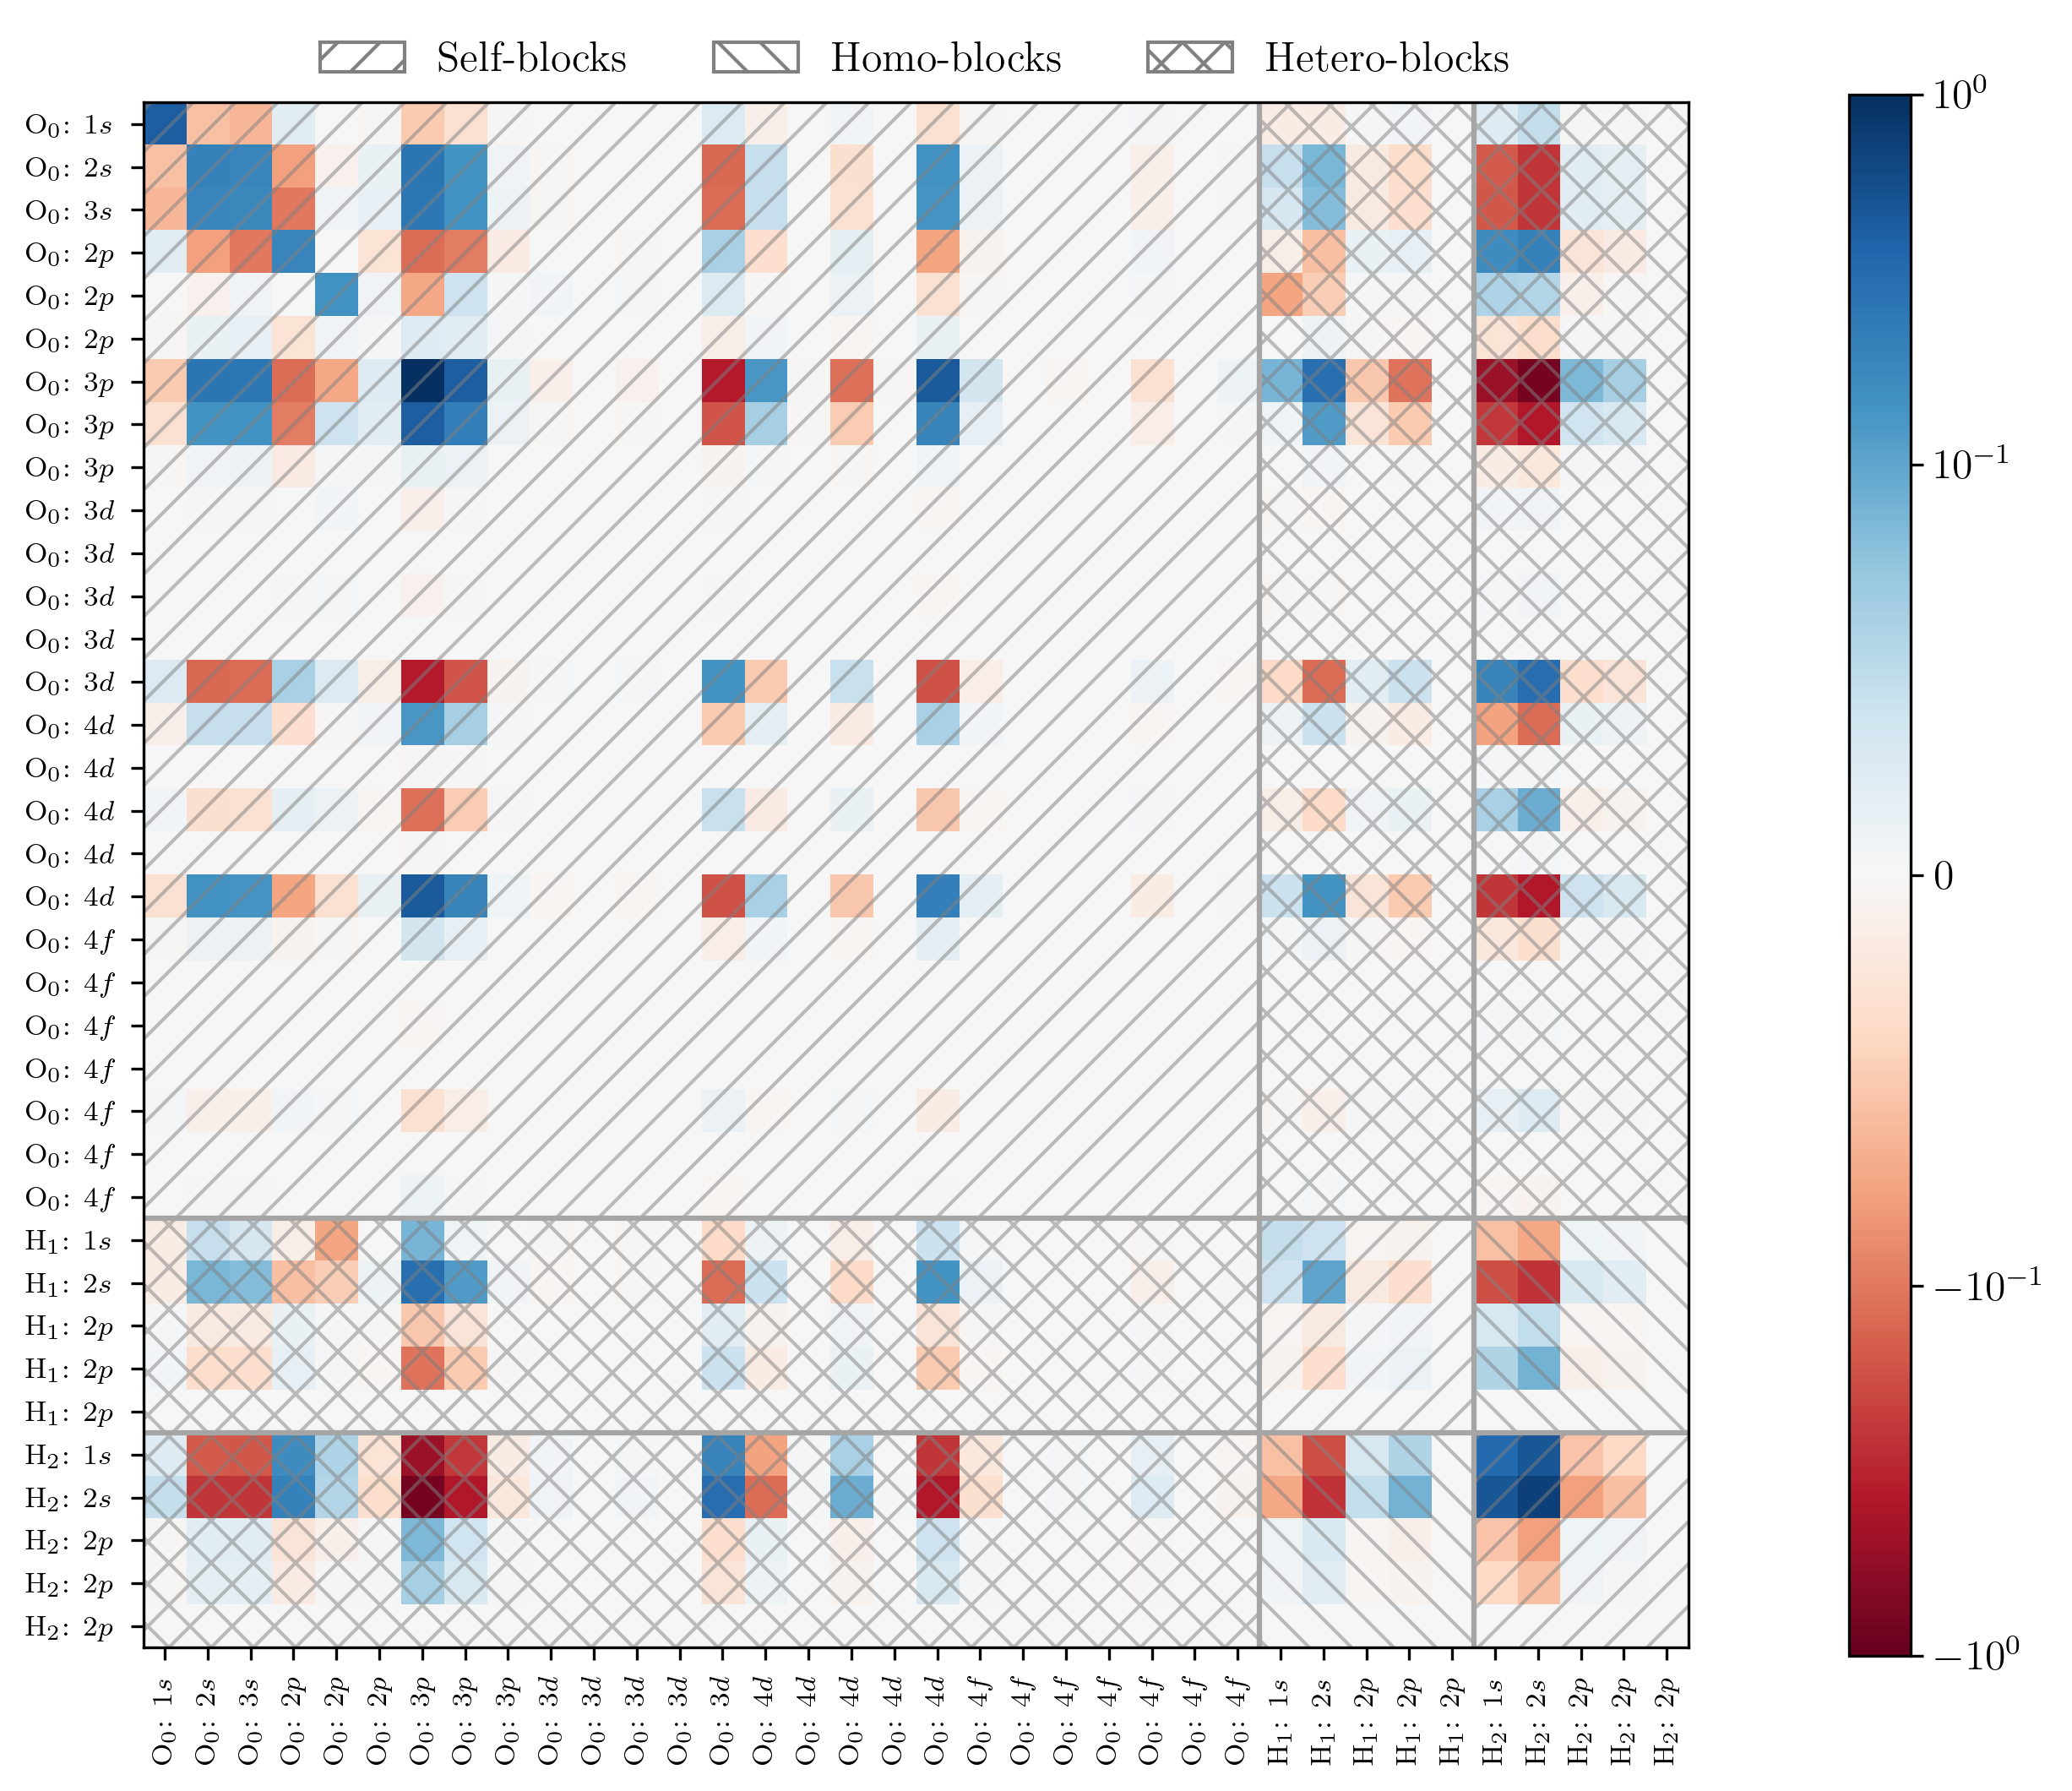

In [142]:
hatches = [
    ("Self-blocks", "//", (0, 25, 0, 25)),  
    ("Self-blocks", "//", (26, 30, 26, 30)),  
    ("Self-blocks", "//", (31, 35, 31, 35)),  
    ("Homo-blocks", "\\\\", (31, 35, 26, 30)),  
    ("Homo-blocks", "\\\\", (26, 30, 31, 35)),  
    ("Hetero-blocks", "xx", (0, 25, 26, 30)),  
    ("Hetero-blocks", "xx", (0, 25, 31, 35)),  
    ("Hetero-blocks", "xx", (26, 30, 0, 25)),  
    ("Hetero-blocks", "xx", (31, 35, 0, 25)),  
]
plotschematicBlocks(density, mol, "../../fig/gnn/schematic_blocks.pdf", vmax=1, hatched_regions=hatches)# labels="atoms")

In [143]:
mol = gto.Mole()
mol.atom = filepath
mol.basis = "sto-3g"
mol.unit = 'Angstrom'
mol.charge = 0
mol.spin = 0
mol.symmetry = False
mol.build()

# RKS-DFT mit PBE
mf = dft.RKS(mol)
mf.xc = 'b3lypg'                # DFT-Funktional (z.B. 'B3LYP', 'PBE', 'LDA' ...)
mf.conv_tol = 1e-10           # Konvergenz-Toleranz
mf.kernel()

overlap = mf.get_ovlp() 

converged SCF energy = -75.3139398910609


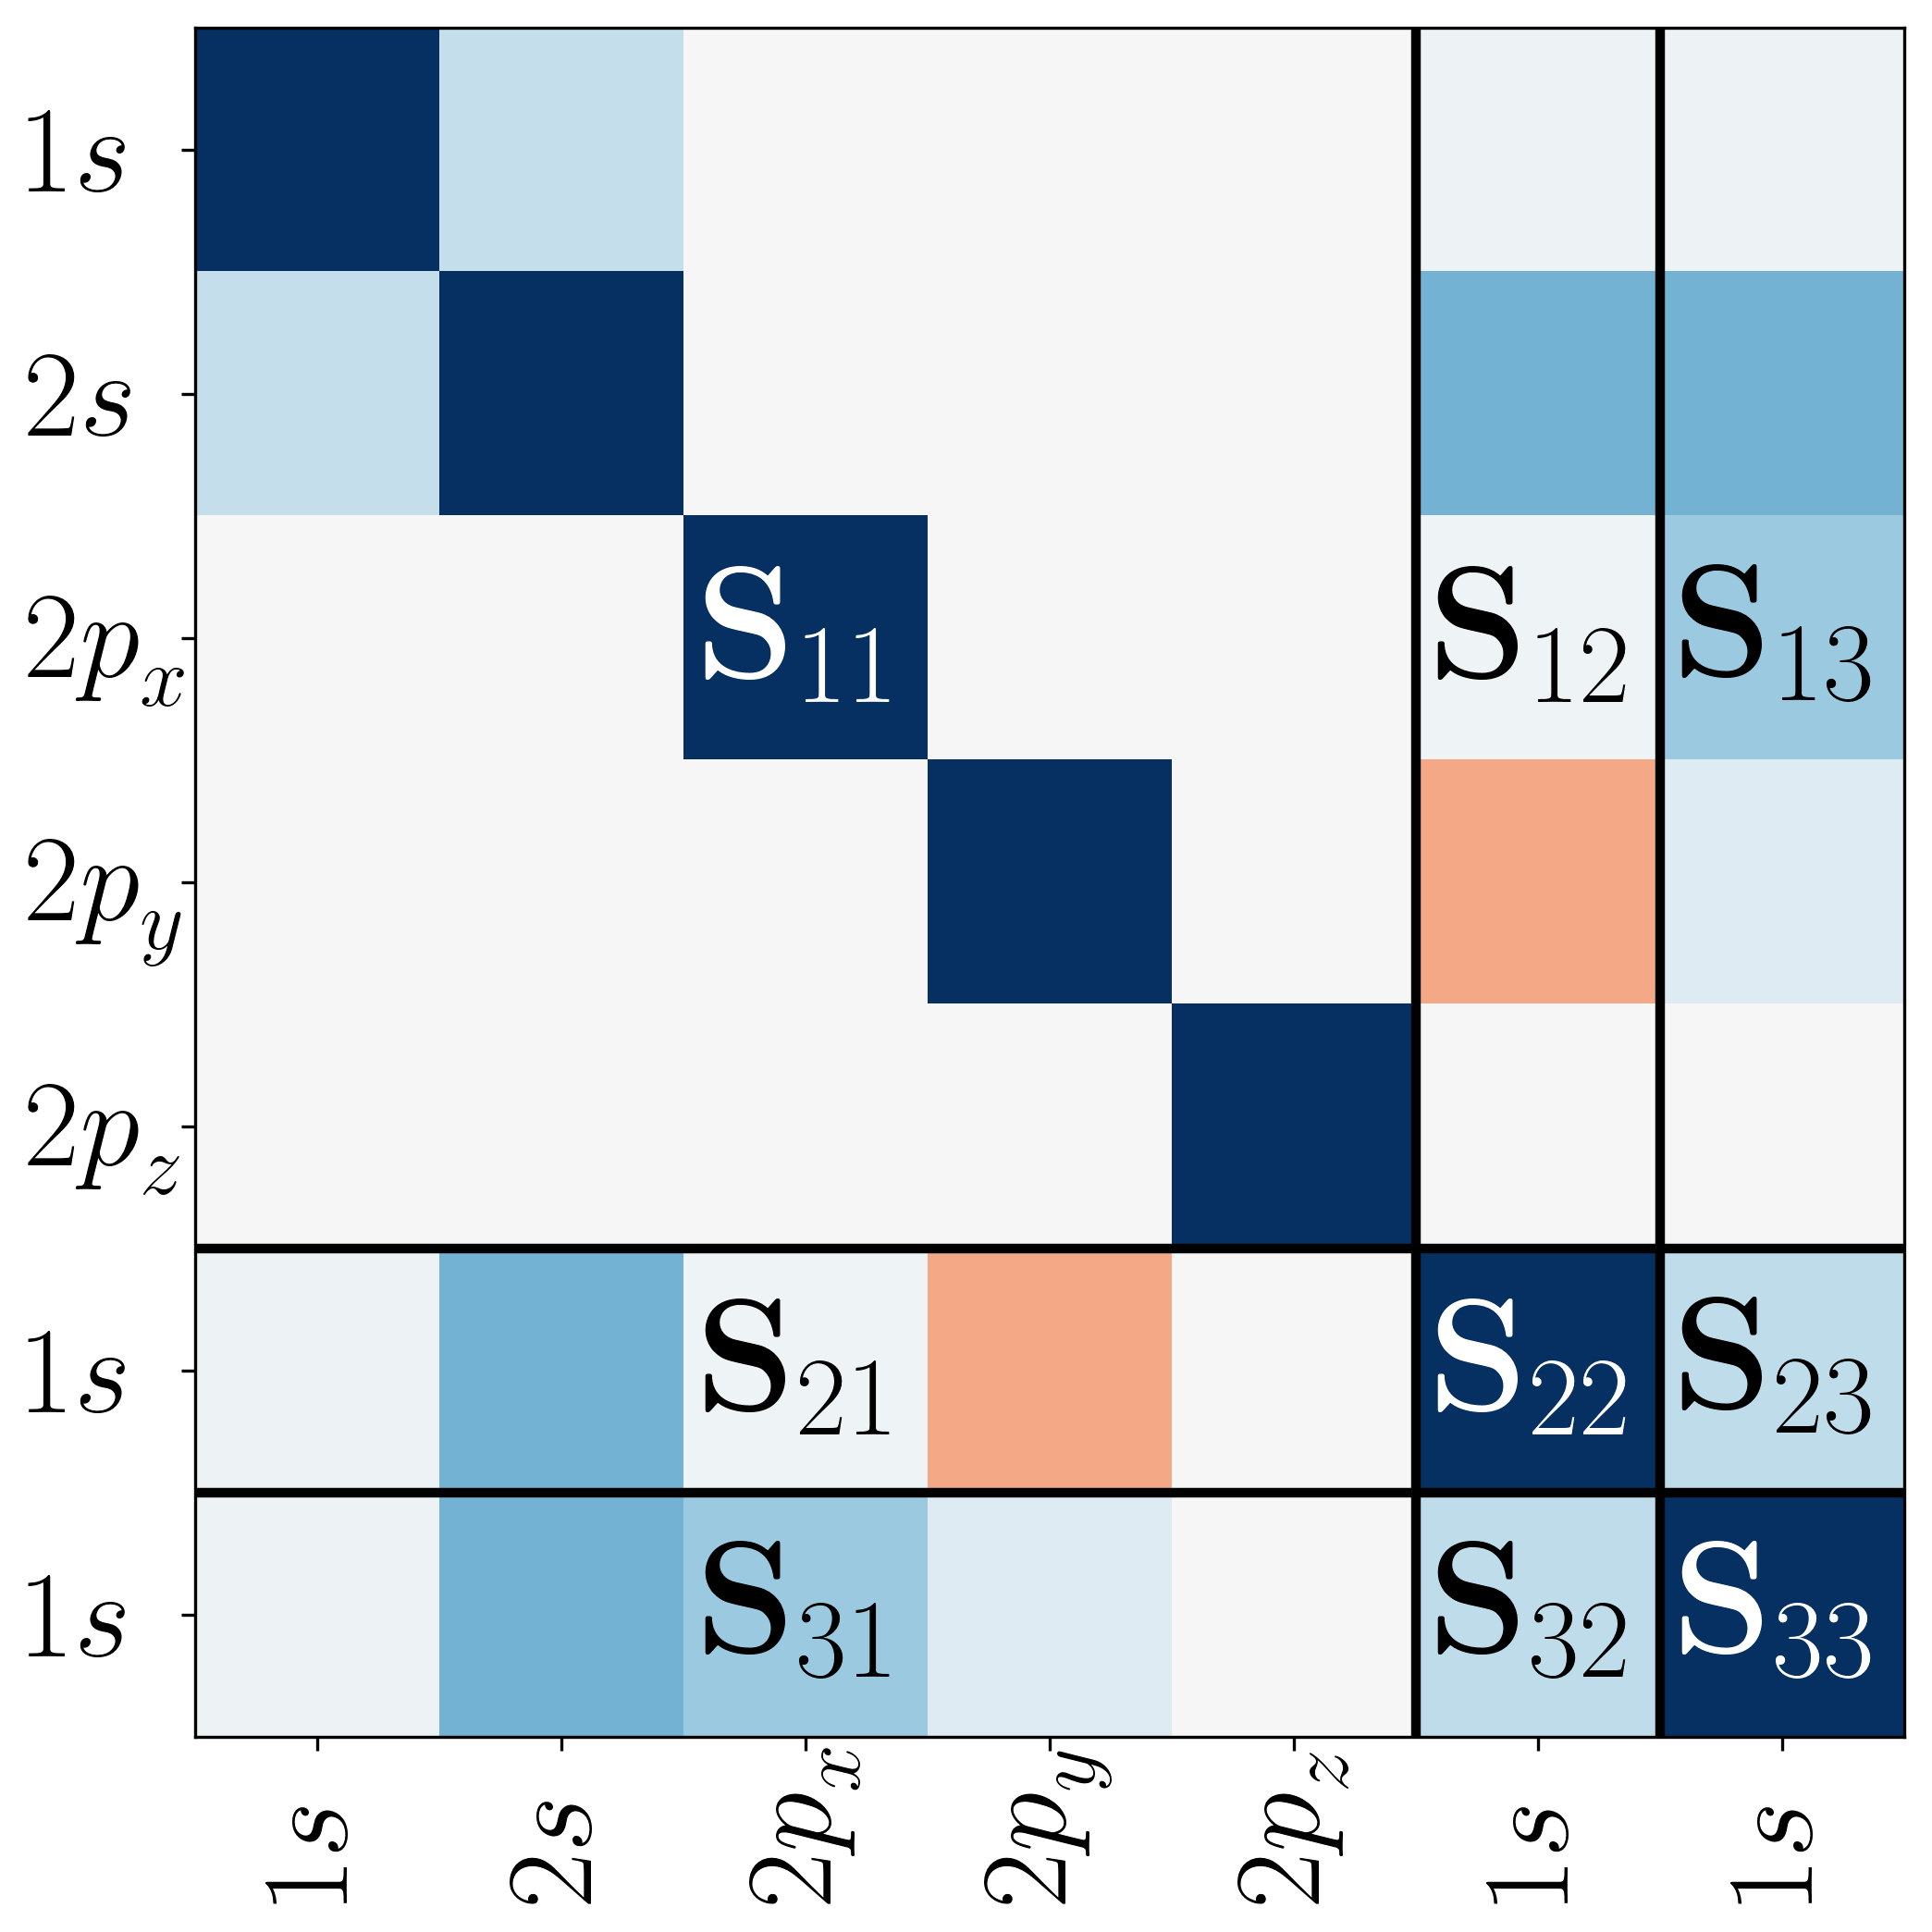

In [208]:
def schematicBlock(X, M, plotname, labelsize=8, vmax=1):
    import matplotlib.pyplot as plt
    from matplotlib.colors import SymLogNorm

    fig, ax0 = plt.subplots(figsize=(9, 8))
    ax = [ax0]
    norm = SymLogNorm(linthresh=1e-1, linscale=1.0, vmin=-vmax, vmax=vmax)

    im = ax[0].imshow(X, cmap='RdBu', vmin=-vmax, vmax=vmax)#norm=norm)

    labels_ = [f"${{{label.split()[2][:2]}}}_{{{label.split()[2][2:]}}}$" for label in M.ao_labels()]
    ax[0].set_xticks(range(len(labels_)))
    ax[0].set_xticklabels(labels_, rotation=90, fontsize=labelsize, va='bottom')
    ax[0].set_yticks(range(len(labels_)))
    ax[0].set_yticklabels(labels_, fontsize=labelsize, ha='left')
    ax[0].tick_params(axis='x', labelbottom=True, pad=40)
    ax[0].tick_params(axis='y', labelleft=True, pad=40)
    ax[0].grid(False)

    # AO atom IDs
    ao_labels = M.ao_labels()
    atom_names = [label.split()[1] + label.split()[0] for label in ao_labels]

    # Block boundaries where atom changes
    boundaries = [0] + [i for i in range(1, len(atom_names)) if atom_names[i] != atom_names[i-1]] + [len(atom_names)]

    # draw boundary lines
    for b in boundaries[1:-1]:
        ax[0].axhline(b - 0.5, color="black", lw=2.5)
        ax[0].axvline(b - 0.5, color="black", lw=2.5)

    # label subblocks with P_ij
    for i in range(len(boundaries) - 1):
        for j in range(len(boundaries) - 1):
            i_start, i_end = boundaries[i], boundaries[i + 1]
            j_start, j_end = boundaries[j], boundaries[j + 1]
            label = r"$\mathbf{S}_"+f"{{{i+1}{j+1}}}$"
            x_center = (j_start + j_end - 1) / 2
            y_center = (i_start + i_end - 1) / 2
            c = "white" if i == j else "black"
            ax[0].text(x_center, y_center, label,
                       ha='center', va='center',
                       fontsize=labelsize * 1.3,
                       color=c,
                       )

    plt.savefig(f"{plotname}", bbox_inches="tight", dpi=600)

schematicBlock(overlap, mol, "../../fig/gnn/sto-3g_schematic_embeddings.png", labelsize=32)

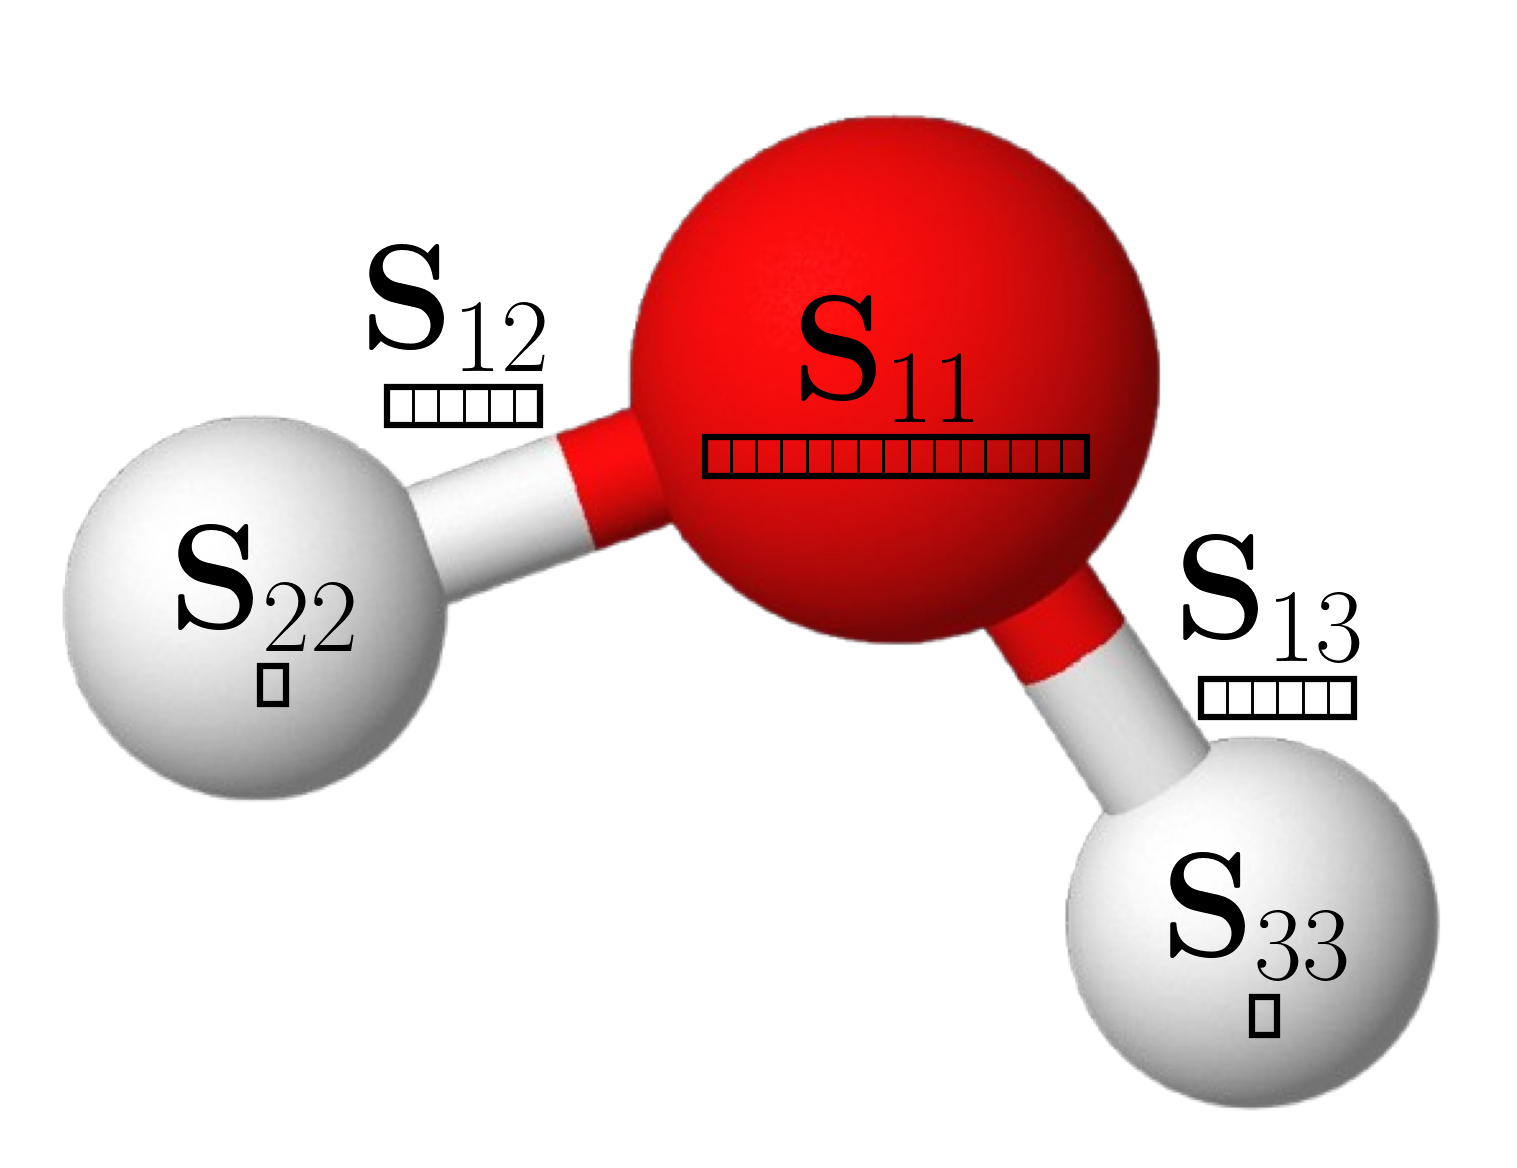

In [216]:
from matplotlib import patches
import matplotlib.image as mpimg

def label_atoms_on_image(image_path, save_path=None):
    img = mpimg.imread(image_path)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis('off')  # Hide axes

    # Example positions – change manually later
    # ax.text(330, 200, '$1$', fontsize=50, color='black', weight='bold')
    # ax.text(65, 230, '$2$', fontsize=50, color='black', weight='bold')
    # ax.text(400, 400, '$3$', fontsize=50, color='black', weight='bold')

    embeddings = {
        r"$\mathbf{S}_{11}$": (340, 160, 15),
        r"$\mathbf{S}_{22}$": (95, 250, 1),
        r"$\mathbf{S}_{33}$": (485, 380, 1),
        r"$\mathbf{S}_{12}$": (170, 140, 6),
        r"$\mathbf{S}_{13}$": (490, 255, 6),
        # r"$S_{23}$": (30, 100, 1),
    }

    for label, (x, y, len_) in embeddings.items():
        num_cells = len_
        cell_width = 10
        cell_height = 15
        total_width = num_cells * cell_width

        # äußere Box
        rect = patches.Rectangle((x-total_width/2, y), total_width, cell_height,
                                linewidth=1.5, edgecolor='black', facecolor='none')
        ax.add_patch(rect)

        # vertikale Zelllinien
        for i in range(1, num_cells):
            xpos = (x-total_width/2) + i * cell_width
            ax.plot([xpos, xpos], [y, y + cell_height], color='black', linewidth=0.7)

        # Label darüber
        ax.text(x, y - 30, label, ha='center', va='center', fontsize=36)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, transparent=True)
    plt.show()
label_atoms_on_image("plot_data/h2o.png","../../fig/gnn/sto-3g_schematic_embeddings_h2o.png" )

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

def draw_embedding_overlay(image_path, save_path=None):
    img = mpimg.imread(image_path)
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.axis('off')

    # === Atom label positions (x, y) ===
    atom_positions = {
        "O₁": (170, 120),
        "H₂": (60, 140),
        "H₃": (220, 250)
    }

    for label, (x, y) in atom_positions.items():
        ax.text(x, y, label, fontsize=16, weight='bold', color='black')

    # === Atom embeddings ===
    atom_embeddings = {
        "P₁₁": (170, 50),
        "P₂₂": (30, 100),
        "P₃₃": (260, 290)
    }

    for label, (x, y) in atom_embeddings.items():
        rect = patches.Rectangle((x, y), 40, 15, linewidth=1.5, edgecolor='black', facecolor='lightgray')
        ax.add_patch(rect)
        ax.text(x + 20, y + 7.5, label, ha='center', va='center', fontsize=10)

    # === Bond embeddings === (manually positioned)
    bond_embeddings = {
        "P₁₂": (115, 105),
        "P₁₃": (195, 190)
    }

    for label, (x, y) in bond_embeddings.items():
        rect = patches.Rectangle((x, y), 40, 15, linewidth=1.5, edgecolor='black', facecolor='white', linestyle='dashed')
        ax.add_patch(rect)
        ax.text(x + 20, y + 7.5, label, ha='center', va='center', fontsize=10)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300, transparent=True)

    plt.show()
